# Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Необходимые импорты

In [ ]:
!pip install --upgrade pandas dask lightgbm seaborn scikit-learn -q
!pip install shap -q

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import shap

/Users/dimasidnev/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/dimasidnev/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/dimasidnev/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [661]:
def analyze_residuals(residuals, predictions, model_string=None):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sns.histplot(residuals, ax=axes[0], color='#ECDBBA', bins=20)
    
    if model_string is not None:
        axes[0].set_title(f'Гистограмма распределения остатков [{model_string}]')
    else:
        axes[0].set_title(f'Гистограмма распределения остатков')
        
    axes[0].axvline(x=residuals.mean(), label='среднее', color='red', ls='--')
    axes[0].axvline(x=0, label='нулевой уровень', color='green')
    
    axes[0].legend()
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals)
    
    axes[1].axhline(y=0, color='red', ls='--')
    
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    if model_string is not None:
        axes[1].set_title(f'Анализ дисперсии [{model_string}]')
    else:
        axes[1].set_title(f'Анализ дисперсии')
        
    plt.show()

In [544]:
RANDOM_STATE = 42
TEST_SIZE = .1
DEFAULT_COLOR = '#8174A0'

sns.set_theme()

## Загрузка данных

In [ ]:
try:
    df = pd.read_csv('datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    df = pd.read_csv('path', parse_dates=[0], index_col=[0])

In [546]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [547]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


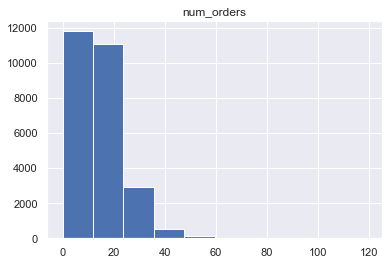

In [548]:
df.hist();

In [549]:
df[['num_orders']].describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [614]:
pd.Series(df.index).describe()

count                   4416
mean     2018-05-31 23:30:00
min      2018-03-01 00:00:00
25%      2018-04-15 23:45:00
50%      2018-05-31 23:30:00
75%      2018-07-16 23:15:00
max      2018-08-31 23:00:00
Name: datetime, dtype: object

/var/folders/tr/sbq7rzq91r3cc22nhkdvgfp80000gn/T/ipykernel_20428/131415965.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum()


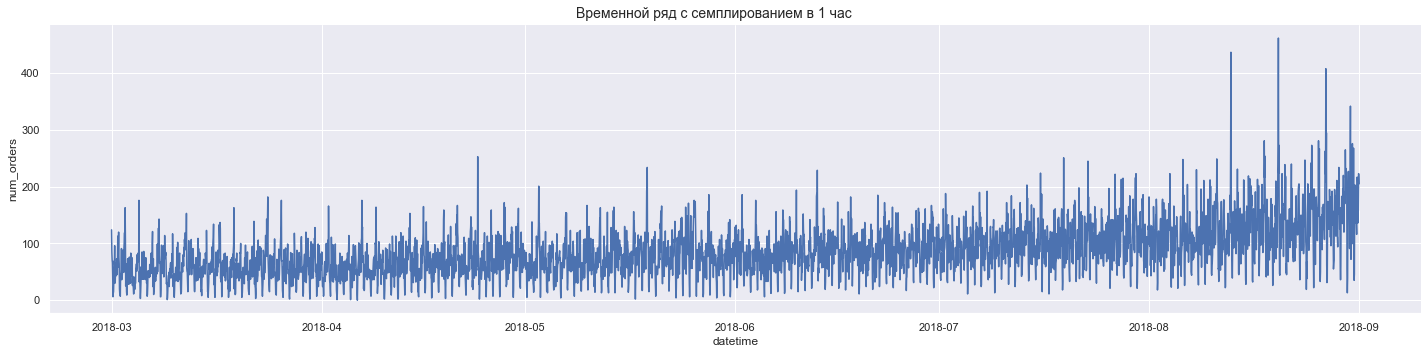

In [550]:
df = df.resample('1H').sum()

g = sns.relplot(
    data=df,
    x="datetime",
    y="num_orders",
    legend=False,
    kind="line",
    aspect=4,
);

g.fig.suptitle('Временной ряд с семплированием в 1 час', fontsize=14);
g.fig.subplots_adjust(top=0.93);

- Видим, что есть некоторый тренд на повышение количества заказов

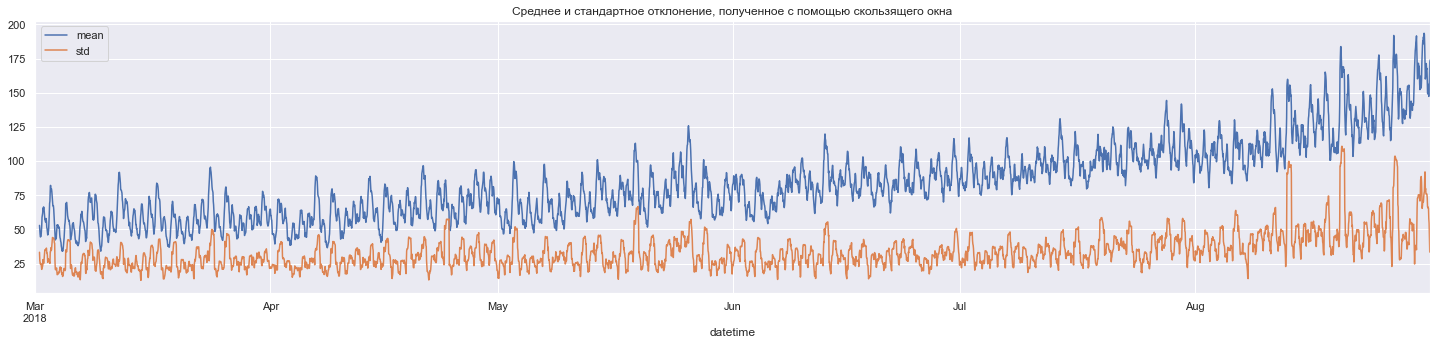

In [551]:
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.drop(columns='num_orders').plot(figsize=(25, 5));
plt.title('Среднее и стандартное отклонение, полученное с помощью скользящего окна');

- Прошлись скользящим окном по данным. Видим, что назвать этот случайный процесс стационарным сложно
- Среднее имеет тренд на рост, а стандартное отклонение меняет свою амплитуду

Проверим ряд на стационарность с помощью критерия Дики-Фуллера

$H_0$: ряд нестационарен

$H_1$: ряд стационарен

уровень значимости $\alpha=0.05$

In [552]:
result = adfuller(df['num_orders'])
print('p-value:', result[1])    
if result[1] <= 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд нестационарен (не отвергаем H0)")

p-value: 0.02894005140261345
Ряд стационарен (отвергаем H0)


Однако, согласно критерию Дики-Фуллера ряд все же стационарен. Значит нам проще будет интерпретировать и выделять из него компоненты тренда и сезонности, а также прогнозы модели будут достаточно устойчивыми

In [553]:
decomposed = seasonal_decompose(df['num_orders'])

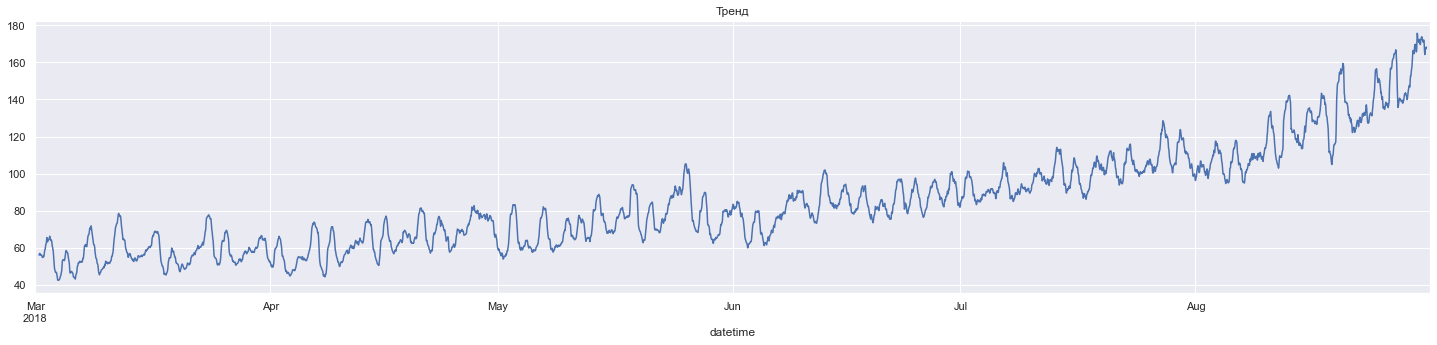

In [554]:
decomposed.trend.plot(figsize=(25, 5), title='Тренд');

- Четко выделяется тренд: количество заказов к осени 2018 года растет 

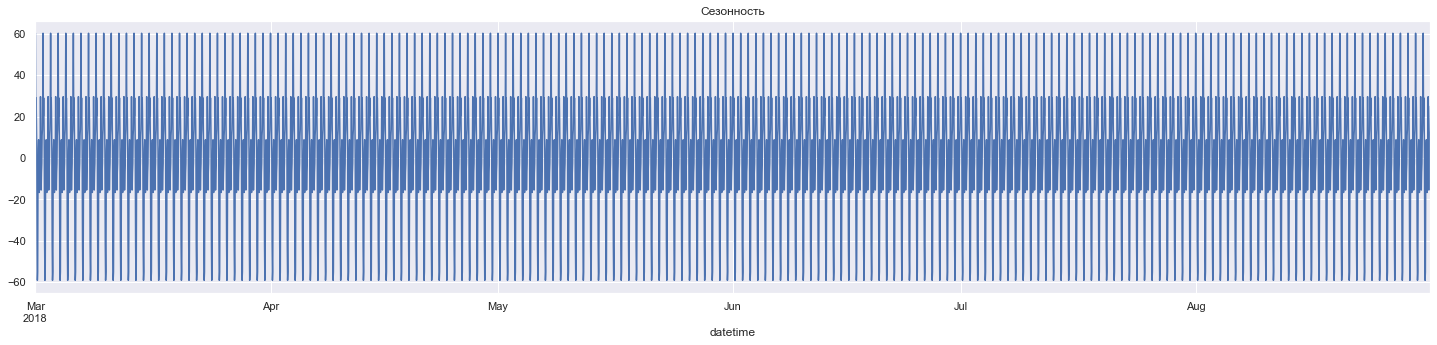

In [555]:
decomposed.seasonal.plot(figsize=(25, 5), title='Сезонность');

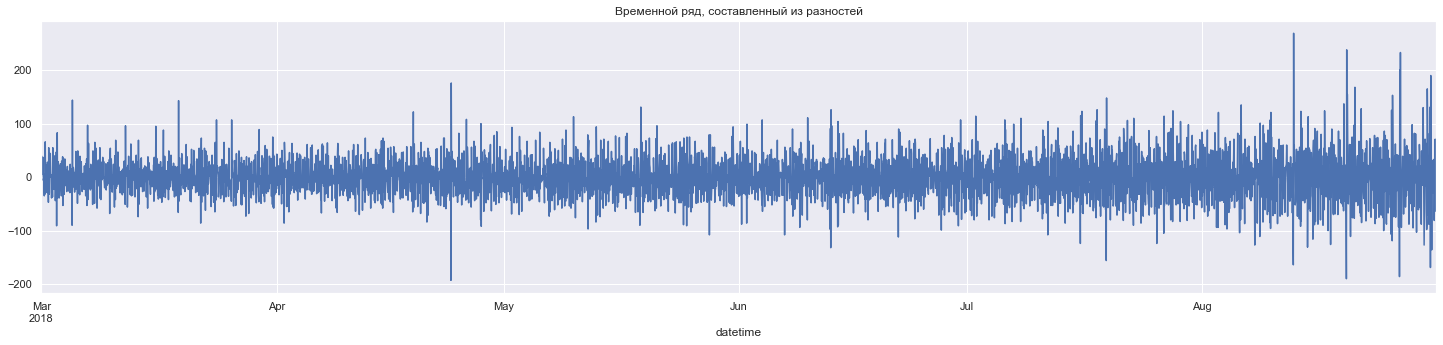

In [556]:
(df['num_orders'].shift() - df['num_orders']).plot(figsize=(25, 5), title='Временной ряд, составленный из разностей');

In [557]:
result = adfuller((df['num_orders'].shift() - df['num_orders']).dropna())
print('p-value:', result[1])    
if result[1] <= 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд нестационарен (не отвергаем H0)")

p-value: 1.0958776746532319e-28
Ряд стационарен (отвергаем H0)


Ряд из разностей является тоже стационарным по критерию Дики-Фуллера

- Через разложение получили похожие результаты. Наблюдается тренд на рост количества заказов

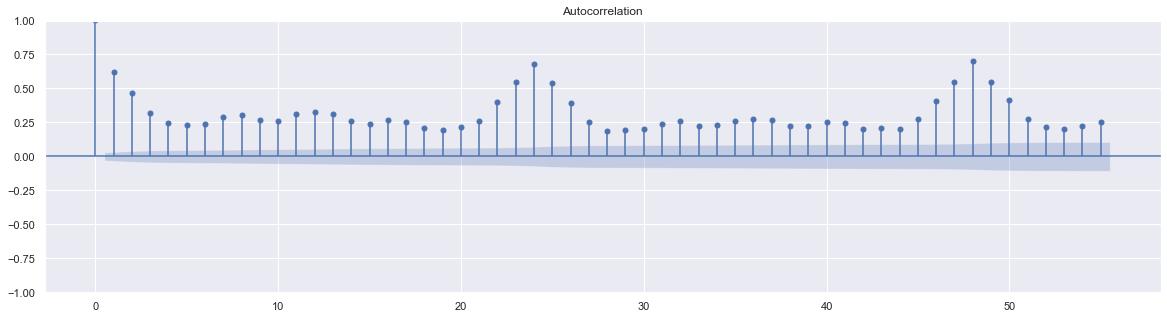

In [682]:
fig = plot_acf(df['num_orders'], lags=55)
fig.set_size_inches(20, 5)

- По графику автокорреляционной функции видим, что есть циклическая компонента с периодом в 24 лага. То есть существует высокая корреляция текущего ряда и ряда сдвинутого на 24 единицы (24 часа)

## Создание признаков 

In [726]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [829]:
ROLLING_SIZE = 50
MAX_LAG = 24

In [830]:
make_features(df, MAX_LAG, ROLLING_SIZE)

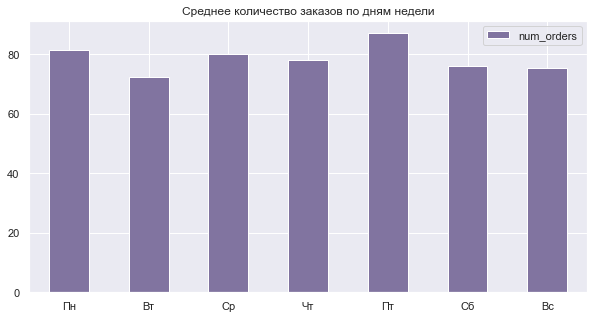

In [831]:
(df
 .pivot_table(index='dayofweek', values='num_orders', aggfunc='median')
 .set_axis(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], axis=0)
 .plot(kind='bar', 
       color=DEFAULT_COLOR, 
       figsize=(10, 5), 
       title='Среднее количество заказов по дням недели'))
plt.xticks(rotation=0);

- Итак, видим, что в среднем самыми загруженными днями являются понедельник и пятница
- Меньше всего заказов в среднем во вторник

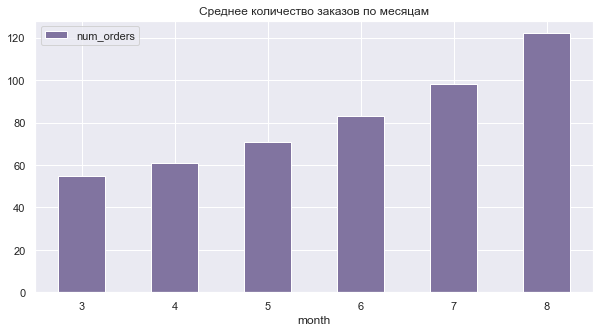

In [832]:
(df
 .pivot_table(index='month', values='num_orders', aggfunc='median')
 .plot(kind='bar', 
       color=DEFAULT_COLOR, 
       figsize=(10, 5), 
       title='Среднее количество заказов по месяцам'))
plt.xticks(rotation=0);

- Наблюдаем рост среднего значения заказов от марта до августа
- Пиковая средняя активность - август 2018 года

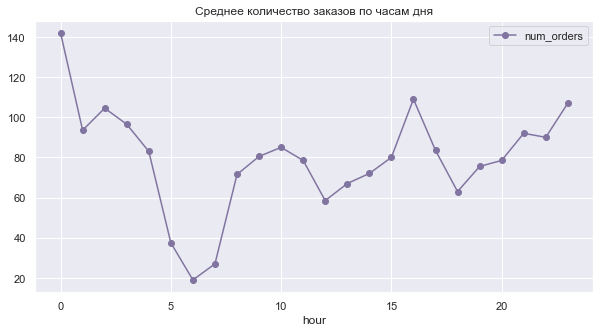

In [833]:
(df
 .pivot_table(index='hour', values='num_orders', aggfunc='median')
 .plot(marker='o',
       color=DEFAULT_COLOR, 
       figsize=(10, 5), 
       title='Среднее количество заказов по часам дня'))
plt.xticks(rotation=0);

- Минимум среднего числа заказов приходится на 5 утра
- Максмально оно в полночь, также есть пик в 16:00

In [834]:
df['is_second_part_of_the_day'] = (df['hour'] >= 12).astype(int)

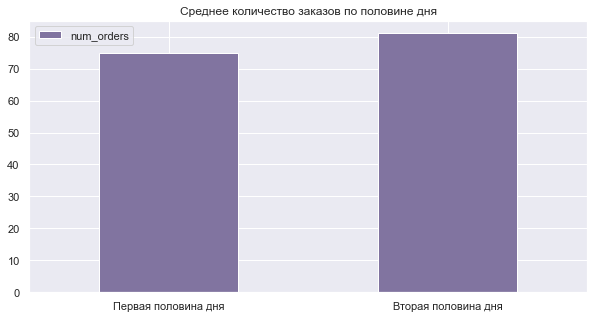

In [835]:
(df
 .pivot_table(index='is_second_part_of_the_day', values='num_orders', aggfunc='median')
 .set_axis(['Первая половина дня', 'Вторая половина дня'], axis=0)
 .plot(kind='bar', 
       color=DEFAULT_COLOR, 
       figsize=(10, 5), 
       title='Среднее количество заказов по половине дня'))
plt.xticks(rotation=0);

- Видим, что во второй половине дня среднее число заказов немного выше, чем в первой половине дня

Вывод по анализу данных:

- У нас есть данные от марта 2018 года до конца августа 2018 года, поэтому год выделять в признаках смысла нет: он будет одним и тем же для всех строк
- У временного ряда имеется тренд к росту (растет также его среднее и пульсирует стандартное отклонение, полученное через скользящее окно)
- По критерию Дики-Фуллера ряд получился стационарным с уровнем значимости $\alpha=0.05$, также ряд, составленный из разностей последующих и предыдущих значений получился стационарным
- Декомпозиция на тренд и сезонность выявила сильный тренд роста числа заказов к августу 2018 года
- Анализ медианных значений количества заказов по дням недели выявил два самых загруженных дня: ПН и ПТ, наименее загруженным в среднем является ВТ.
- Среднее количество заказов за каждый месяц, представленный в выборке, растет, приближаясь к пиковому значению - август 2018 года
- Кроме того, из данных был вычленен час заказа (после ресемплирования по часу эти данные сохранились). Оказалось, что наибольшее среднее число заказов достигается в полночь или в 16:00. Наименьшая же нагрузка в 5 утра
- Во второй половине дня в среднем заказов все же чуть больше, чем в первой

## Обучение моделей

In [836]:
df = df.drop(columns=['mean', 'std', 'week', 'is_second_part_of_the_day'], errors='ignore')

In [837]:
df.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [838]:
train, test = train_test_split(df, 
                               test_size=TEST_SIZE, 
                               shuffle=False, # запрещаем перемешиивание, чтобы модели не смогли "заглянуть в будущее"
                               random_state=RANDOM_STATE)

In [839]:
train = train.dropna()
train_data = train.drop(columns='num_orders')
train_target = train.num_orders

test_data = test.drop(columns='num_orders')
test_target = test.num_orders

In [840]:
pipe = Pipeline([
    ('models', LinearRegression())
])

In [841]:
param_grid_ridge = [
    {
        'models': [Ridge()],
        'models__alpha': [0.001, 0.01, 0.1, 1, 0.00001],
    }
]

regressor_ridge = RandomizedSearchCV(
    pipe, 
    param_grid_ridge, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
)
regressor_ridge.fit(train_data, train_target)

/Users/dimasidnev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('models', LinearRegression())]),
                   param_distributions=[{'models': [Ridge()],
                                         'models__alpha': [0.001, 0.01, 0.1, 1,
                                                           1e-05]}],
                   scoring='neg_root_mean_squared_error')

In [842]:
param_grid_lasso = [
    {
        'models': [Lasso()],
        'models__alpha': [0.001, 0.01, 0.1, 1, 0.00001, 2],
    }
]

regressor_lasso = RandomizedSearchCV(
    pipe, 
    param_grid_lasso, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
)
regressor_lasso.fit(train_data, train_target)

/Users/dimasidnev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('models', LinearRegression())]),
                   param_distributions=[{'models': [Lasso()],
                                         'models__alpha': [0.001, 0.01, 0.1, 1,
                                                           1e-05, 2]}],
                   scoring='neg_root_mean_squared_error')

In [843]:
param_grid_rf = [
    {
        'models': [RandomForestRegressor(n_estimators=150, n_jobs=-1)],
        'models__max_depth': [4, 5, 8, 10, 12],
        'models__max_features': range(2, 12, 1),
        'models__min_samples_leaf': range(1, 10, 1),
        'models__min_samples_split': range(2, 10, 1),
    }
]

regressor_rf = RandomizedSearchCV(
    pipe, 
    param_grid_rf, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
)
regressor_rf.fit(train_data, train_target)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('models', LinearRegression())]),
                   param_distributions=[{'models': [RandomForestRegressor(n_estimators=150,
                                                                          n_jobs=-1)],
                                         'models__max_depth': [4, 5, 8, 10, 12],
                                         'models__max_features': range(2, 12),
                                         'models__min_samples_leaf': range(1, 10),
                                         'models__min_samples_split': range(2, 10)}],
                   scoring='neg_root_mean_squared_error')

In [845]:
param_grid_lgb = [
    {
        'models': [lgb.LGBMModel(objective="regression", n_estimators=10, n_jobs=-1, verbosity=-1)],
        'models__n_estimators': [10, 150, 300],
        'models__max_depth': [4, 5, 8, 10, 12],
        
    }
]

regressor_lgb = RandomizedSearchCV(
    pipe, 
    param_grid_lgb, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
)
regressor_lgb.fit(train_data, train_target)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('models', LinearRegression())]),
                   param_distributions=[{'models': [LGBMModel(n_estimators=10,
                                                              n_jobs=-1,
                                                              objective='regression',
                                                              verbosity=-1)],
                                         'models__max_depth': [4, 5, 8, 10, 12],
                                         'models__n_estimators': [10, 150,
                                                                  300]}],
                   scoring='neg_root_mean_squared_error')

In [846]:
param_grid_tree = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 8, 1),
        'models__max_features': range(2, 8, 1),
    }
]

regressor_tree = RandomizedSearchCV(
    pipe, 
    param_grid_tree, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    error_score='raise',
)
regressor_tree.fit(train_data, train_target)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('models', LinearRegression())]),
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(2, 8),
                                         'models__max_features': range(2, 8)}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [847]:
pipes_list = [regressor_ridge, regressor_lasso, regressor_rf, regressor_lgb, regressor_tree]

In [848]:
results = pd.DataFrame([{"RMSE (train)":
    (-1) * p.best_score_,
    "mean fit time": p.cv_results_['mean_fit_time'][p.best_index_]
                         
} for p in pipes_list], index=['Ridge', 'Lasso', 'RF', 'LGBM', 'DecTree']).round(3)

In [849]:
results

,RMSE (train),mean fit time
Ridge,25.840,0.011
Lasso,25.791,0.016
RF,23.940,0.599
LGBM,23.107,0.118
DecTree,30.391,0.013


- На основании кросс-валидации и подбора гиперпараметров делаем вывод, что лучше всех себя проявил LGBM бустинг, его ошибка на кросс-валидации самая низкая, время обучения приемлемое (по этому критерию его обходят практически все использованные модели за исключением случайного леса)

- Остается протестировать ее на тестовых данных

In [850]:
round(root_mean_squared_error(regressor_lgb.predict(test_data), test_target), 2)

39.78

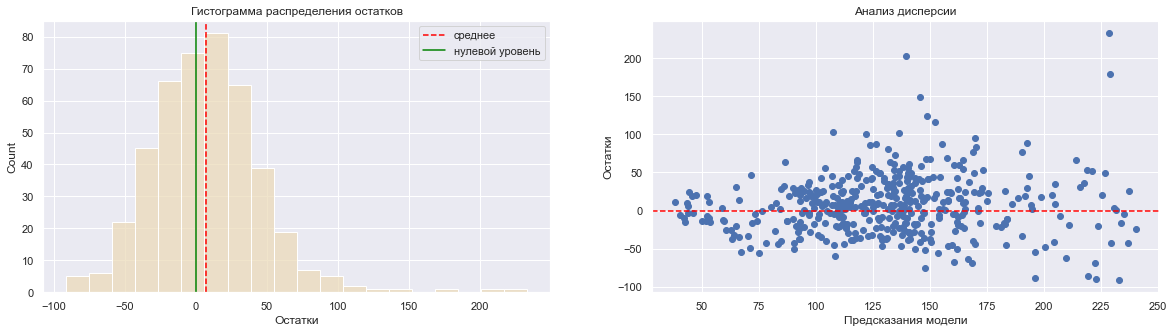

In [851]:
predictions = regressor_lgb.predict(test_data)
residuals = (test_target - predictions)
analyze_residuals(residuals, predictions)

- Итак, видим, что среднее предсказаний смещено вправо: модель несколько занижает предсказания
- Дисперсия предсказаний неравномерная. От 80 до 175 все достаточно равномерно, но для предсказаний ниже 80 или выше 175 есть дисперсия выглядит иначе. В частности, для малых предсказаний (от 50 до 80) модель преимущественно завышает оценку

In [852]:
residuals.mean().round(2)

7.57

- Видим, что модель в среднем ошибается на 7-8 заказов. 
- В рамках условий данного проекта качество предложенной модели является удовлетворительным

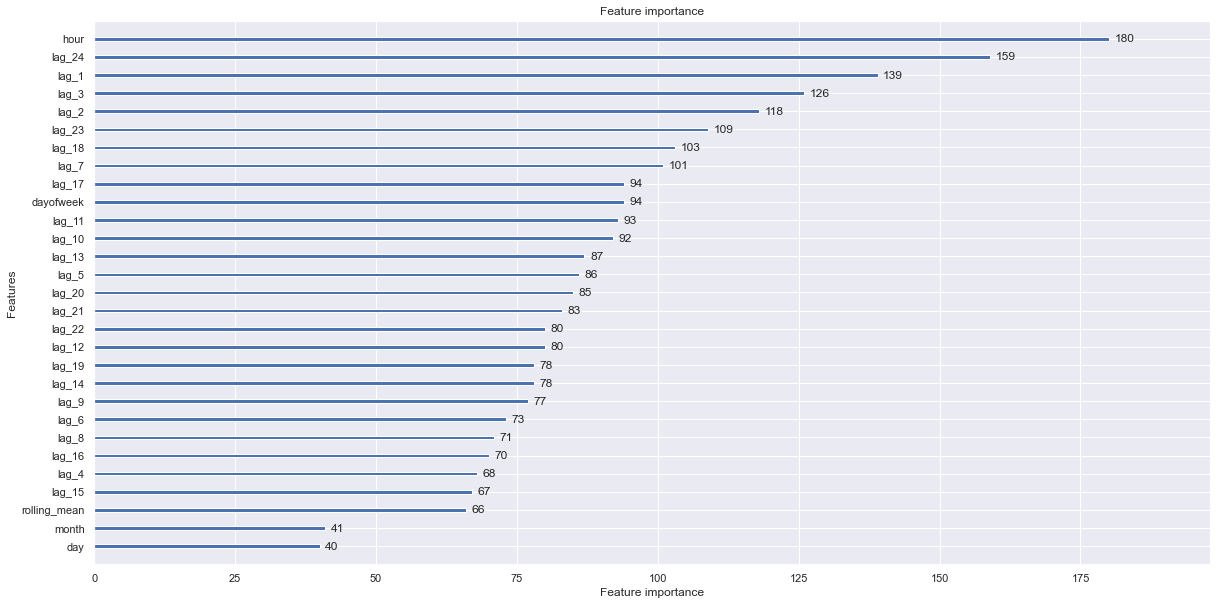

In [853]:
lgb.plot_importance(regressor_lgb.best_estimator_.named_steps['models'].booster_, figsize=(20, 10));

- Видим, что самый важный признак бустинга - час заказа
- Затем идет лаг на 24 часа, то есть число заказов в тот же час, но за предыдущий день. Логично, на этапе анализа мы выявили циклическую компоненту
- Наименее важным бустинг посчитал день заказа

In [854]:
explainer = shap.TreeExplainer(regressor_lgb.best_estimator_.named_steps['models'].booster_)
shap_values = explainer(test_data) 

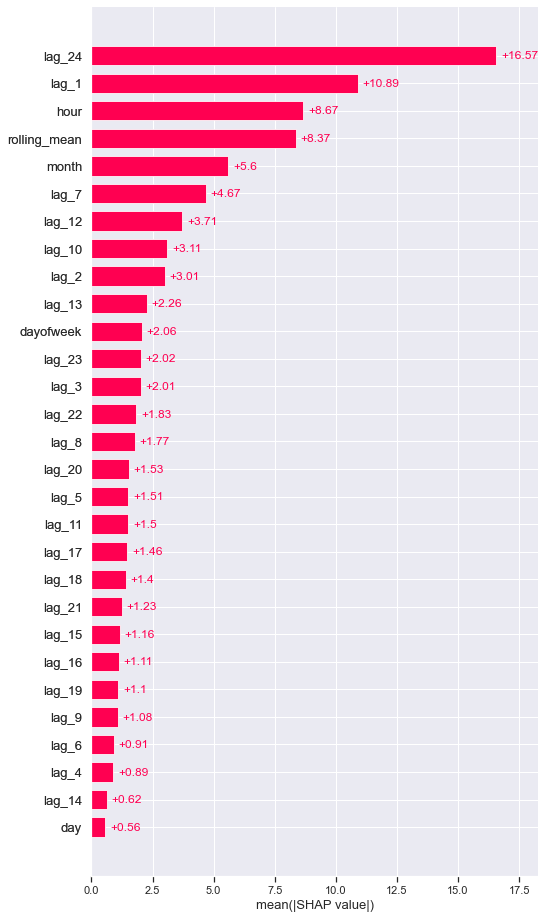

In [855]:
shap.plots.bar(shap_values, max_display=30)

- SHAP анализ придерживается иного мнения, для него самыми важными являются лаг за предыдущий час и за предыдущий день, а уже только потом час заказа
- Наименее важен также день заказа

То есть SHAP анализ показывает, что модели все таки больше важны исторические данные

## Вывод

- Сначала мы изучали общий вид данных, затем просемплировали их по 1 часу
- Выявили, что по критерию Дики-Фуллера ряд является стационарным с уровнем значимости в 5%, точно такой же вывод был сделан и для ряда из разностей. Хотя визуально исходный ряд имеет переменное среднее и пульсирующее стандартное отклонение.
- На основе разложение на тренд и сезонность выявили восходящий тренд. Рост числа заказов ближе к августу 2018 года
- С помощью автокорреляции нашли циклическую компоненту. Оказывается, что ряд имеет высокую корреляцию с самим собой, сдвинутым на 24 отсчета.
- Затем был проведен feature engineering. Были добавлен лаги вплоть до 24 отсчетов и выделены основные компоненты даты в отдельные признаки
- По исследовательскому анализу были получены следующие результаты:

    - У нас есть данные от марта 2018 года до конца августа 2018 года, поэтому год выделять в признаках смысла нет: он будет одним и тем же для всех строк

    - Анализ медианных значений количества заказов по дням недели выявил два самых загруженных дня: ПН и ПТ, наименее загруженным в среднем является ВТ.
    - Среднее количество заказов за каждый месяц, представленный в выборке, растет, приближаясь к пиковому значению - август 2018 года
    - Кроме того, из данных был вычленен час заказа (после ресемплирования по часу эти данные сохранились). Оказалось, что наибольшее среднее число заказов достигается в полночь или в 16:00. Наименьшая же нагрузка в 5 утра
    - Во второй половине дня в среднем заказов все же чуть больше, чем в первой
    
- Затем были обучены с помощью пайплайнов модели, среди которых лучший результат на кросс-валидации показал градиентный бустинг LGBM. 

- На основе тестовых данных была получена итоговая оценка качества модели, которая удовлетворяет условиям проекта

- Далее были проанализированы остатки модели. Анализ показал, что модель занижает предсказания в среднем на 7-8 заказов

- Анализ важности признаков показал, что лаг за предыдущий час, предыдущий день и час заказа наиболее важны для предсказания. Однако shap анализ показал, что модель все же склонна верить больше историческим данным (сдвинутым показаниям исходного ряда)